In [23]:
%load_ext autoreload
%autoreload 2

# MODEL CLASS

import matplotlib.pyplot as plt

from collections import defaultdict
import os

import torch.nn as nn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
%cd /om2/user/valmiki/bioplnn

/rdma/vast-rdma/user/valmiki/bioplnn


/om2/user/valmiki/miniconda/envs/pytorch/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [25]:
from collections.abc import Iterable
from math import ceil, prod
from typing import Optional
from warnings import warn

import torch
import torch.nn as nn

from bioplnn.utils import get_activation_class


class AttentionalGainModulation(nn.Module):
    def __init__(self, in_channels, spatial_size: tuple[int, int]):
        """
        Initializes the SimpleAttentionalGain module.

        Args:
            spatial_size (tuple[int, int]): The spatial size of the input tensors (H, W).

        """
        super().__init__()

        self.spatial_average = nn.AdaptiveAvgPool2d(spatial_size)

        self.bias = nn.Parameter(torch.zeros(1))  # init gain scaling to zero
        self.slope = nn.Parameter(torch.ones(1))  # init slope to one
        self.threshold = nn.Parameter(torch.zeros(1))  # init threshold to zero

    def forward(self, cue, mixture):
        """
        Forward pass of the EI model.

        Args:
            cue (torch.Tensor): The cue input.
            mixture (torch.Tensor): The mixture input.

        Returns:
            torch.Tensor: The output after applying gain modulation to the mixture input.
        """
        # Process cue
        cue = self.spatial_average(cue)
        # Apply threshold shift
        cue = cue - self.threshold
        # Apply slope
        cue = cue * self.slope
        # Apply sigmoid & bias
        cue = self.bias + (1 - self.bias) * torch.sigmoid(cue)
        # Apply to mixture (element mult)
        return torch.tanh(cue), mixture * cue


class LowRankModulation(nn.Module):
    def __init__(self, in_channels, spatial_size: tuple[int, int]):
        super().__init__()

        self.in_channels = in_channels
        self.spatial_size = spatial_size

        # # B x C x H  W
        # self.W = nn.Parameter(torch.randn(1, hc, hx, 1))
        # self.bias = nn.Parameter(torch.randn(1, hc, hx, 1))

        # outsize is N X C X 1 X 1
        self.spatial_average = nn.AdaptiveAvgPool2d((1, 1))
        self.rank_one_vec_h = nn.Linear(in_channels, spatial_size[0])
        self.rank_one_vec_w = nn.Linear(in_channels, spatial_size[1])

    def forward(self, cue: torch.Tensor, mixture: torch.Tensor):
        # rank_one_vector = torch.matmul(input, self.W) + self.bias
        # # compute the rank one matrix
        # rank_one_perturbation = torch.matmul(rank_one_vector, rank_one_vector.transpose(-2, -1))
        # perturbed_input = input + rank_one_perturbation
        # return perturbed_input

        x = self.spatial_average(cue)
        x = x.flatten(1)
        hvec = self.rank_one_vec_h(x)
        wvec = self.rank_one_vec_w(x)

        rank_one_matrix = torch.bmm(hvec.unsqueeze(-1), wvec.unsqueeze(-2)).unsqueeze(
            -3
        )
        rank_one_tensor = x.unsqueeze(-1).unsqueeze(-1) * rank_one_matrix

        return mixture * rank_one_tensor


class ConvModulation(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        spatial_size: tuple[int, int],
        kernel_size: tuple[int, int] = (3, 3),
        activation: str = "relu",
        bias: bool = True,
    ):
        """
        Initializes the SimpleAttentionalGain module.

        Args:
            spatial_size (tuple[int, int]): The spatial size of the input tensors (H, W).

        """
        super().__init__()
        self.upsample = nn.Upsample(size=spatial_size)
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            padding=(kernel_size[0] // 2, kernel_size[1] // 2),
            bias=bias,
        )
        self.activation = get_activation_class(activation)()
        self.conv2 = nn.Conv2d(
            out_channels,
            out_channels,
            kernel_size,
            padding=(kernel_size[0] // 2, kernel_size[1] // 2),
            bias=bias,
        )

    def forward(self, cues, mixture):
        """
        Forward pass of the EI model.

        Args:
            cue (torch.Tensor): The cue input.
            mixture (torch.Tensor): The mixture input.

        Returns:
            torch.Tensor: The output after applying gain modulation to the mixture input.
        """
        upsampled_cues = []
        for cue in cues:
            upsampled_cues.append(self.upsample(cue))
        cue = torch.cat(upsampled_cues, dim=1)
        cue = self.activation(self.conv1(cue))
        cue = self.conv2(cue)
        cue = torch.sigmoid(cue)
        return mixture * cue


class AttnModulation(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        spatial_size: tuple[int, int],
        kernel_size: tuple[int, int] = (3, 3),
        num_heads=8,
        activation: str = "relu",
        dropout: float = 0.0,
        bias: bool = True,
    ):
        """
        Initializes the EI model.

        Args:
            in_channels (int): The number of input channels.
            spatial_size (tuple[int, int]): The spatial size of the input.

        """
        super().__init__()
        # Initialize the weight and bias matrices
        self.spatial_size = spatial_size
        embed_dim = spatial_size[0] * spatial_size[1]

        self.activation = get_activation_class(activation)()
        self.upsample = nn.Upsample(size=spatial_size)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.qkv = nn.Conv2d(
            out_channels,
            3 * out_channels,
            kernel_size,
            padding=(kernel_size[0] // 2, kernel_size[1] // 2),
            groups=out_channels,
            bias=bias,
        )
        self.attn = nn.MultiheadAttention(
            embed_dim,
            num_heads=num_heads,
            dropout=dropout,
            bias=bias,
            batch_first=True,
        )
        conv1 = nn.Conv2d(
            out_channels,
            out_channels,
            kernel_size,
            padding=(kernel_size[0] // 2, kernel_size[1] // 2),
            groups=out_channels,
            bias=bias,
        )
        conv2 = nn.Conv2d(
            out_channels,
            out_channels,
            kernel_size,
            padding=(kernel_size[0] // 2, kernel_size[1] // 2),
            groups=out_channels,
            bias=bias,
        )
        self.ff = nn.Sequential(conv1, self.activation, conv2)

    def forward(self, cues: list[torch.Tensor], mixture: torch.Tensor):
        """
        Forward pass of the model.

        Args:
            cue (torch.Tensor): The cue tensor.
            mixture (torch.Tensor): The mixture tensor.

        Returns:
            torch.Tensor: The output tensor after adding the rank one perturbation to the mixture.
        """
        # Compute the rank one matrix
        upsampled_cues = []
        for cue in cues:
            upsampled_cues.append(self.upsample(cue))
        cue = torch.cat(upsampled_cues, dim=1)
        cue = self.conv1(cue)
        cue_shape = cue.shape
        cue = self.norm1(cue.flatten(2)).reshape(cue_shape)
        q, k, v = self.qkv(cue).flatten(2).chunk(3, dim=1)
        cue = self.attn(q, k, v, need_weights=False)[0]
        cue = self.norm2(cue).reshape(cue_shape)
        cue = torch.sigmoid(self.ff(cue))
        return mixture * cue


class LowRankPerturbation(nn.Module):
    def __init__(self, in_channels: int, spatial_size: tuple[int, int]):
        """
        Initializes the EI model.

        Args:
            in_channels (int): The number of input channels.
            spatial_size (tuple[int, int]): The spatial size of the input.

        """
        super().__init__()
        # Initialize the weight and bias matrices
        self.W = nn.Parameter(torch.randn(1, in_channels, spatial_size[0], 1))
        self.bias = nn.Parameter(torch.randn(1, in_channels, spatial_size[0], 1))

    def forward(self, input: torch.Tensor):
        """
        Forward pass of the model.

        Args:
            cue (torch.Tensor): The cue tensor.
            mixture (torch.Tensor): The mixture tensor.

        Returns:
            torch.Tensor: The output tensor after adding the rank one perturbation to the mixture.
        """
        # Compute the rank one matrix
        rank_one_vector = torch.matmul(input, self.W) + self.bias
        rank_one_perturbation = torch.matmul(
            rank_one_vector, rank_one_vector.transpose(-2, -1)
        )
        return rank_one_perturbation


class Conv2dPositive(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, *args, **kwargs):
        self.weight.data = torch.relu(self.weight.data)
        if self.bias is not None:
            self.bias.data = torch.relu(self.bias.data)
        return super().forward(*args, **kwargs)


class Conv2dNegative(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, *args, **kwargs):
        self.weight.data = -torch.relu(-self.weight.data)
        if self.bias is not None:
            self.bias.data = -torch.relu(-self.bias.data)
        return -super().forward(*args, **kwargs)


class Conv2dEIRNNCell(nn.Module):
    def __init__(
        self,
        input_size: tuple[int, int],
        input_dim: int,
        h_pyr_dim: int = 4,
        h_inter_dims: tuple[int] = (4),
        fb_dim: int = 0,
        inter_mode: str = "half",
        exc_kernel_size: tuple[int, int] = (5, 5),
        inh_kernel_size: tuple[int, int] = (5, 5),
        num_compartments: int = 3,
        immediate_inhibition: bool = False,
        exc_rectify: Optional[str] = None,
        inh_rectify: Optional[str] = "neg",
        pool_kernel_size: tuple[int, int] = (5, 5),
        pool_stride: tuple[int, int] = (2, 2),
        bias: bool = True,
        pre_inh_activation: Optional[str] = "tanh",
        post_inh_activation: Optional[str] = None,
    ):
        """
        Initialize the ConvRNNEICell.

        Args:
            input_size (tuple[int, int]): Height and width of input tensor as (height, width).
            input_dim (int): Number of channels of input tensor.
            h_pyr_dim (int, optional): Number of channels of the excitatory pyramidal tensor. Default is 4.
            h_inter_dims (tuple[int], optional): Number of channels of the interneuron tensors. Default is (4).
            fb_dim (int, optional): Number of channels of the feedback excitatory tensor. Default is 0.
            exc_kernel_size (tuple[int, int], optional): Size of the kernel for excitatory convolution. Default is (5, 5).
            inh_kernel_size (tuple[int, int], optional): Size of the kernel for inhibitory convolution. Default is (5, 5).
            num_compartments (int, optional): Number of compartments. Default is 3.
            immediate_inhibition (bool, optional): Whether to use immediate inhibition. Default is False.
            pool_kernel_size (tuple[int, int], optional): Size of the kernel for pooling. Default is (5, 5).
            pool_stride (tuple[int, int], optional): Stride for pooling. Default is (2, 2).
            bias (bool, optional): Whether to add bias. Default is True.
            activation (str, optional): Activation function to use. Only 'tanh' and 'relu' activations are supported. Default is "relu".
        """
        super().__init__()
        self.input_size = input_size
        if inter_mode == "half":
            self.inter_size = (ceil(input_size[0] / 2), ceil(input_size[1] / 2))
        elif inter_mode == "same":
            self.inter_size = input_size
        else:
            raise ValueError("inter_mode must be 'half' or 'same'.")
        self.input_dim = input_dim
        self.h_pyr_dim = h_pyr_dim
        h_inter_dims = h_inter_dims if h_inter_dims is not None else []
        if len(h_inter_dims) < 0 or len(h_inter_dims) > 4:
            raise ValueError(
                "h_inter_dims must be a tuple of length 0 to 4, or None."
                f"Got length {len(h_inter_dims)}."
            )
        self.fb_dim = fb_dim
        self.use_fb = fb_dim > 0
        self.immediate_inhibition = immediate_inhibition
        self.num_compartments = num_compartments
        if len(h_inter_dims) == 4 and not self.use_fb:
            warn(
                "The number of interneurons is 4 but fb_dim is 0. Interneuron 3 will not be used"
            )
            h_inter_dims = h_inter_dims[:3]
        self.h_inter_dims = h_inter_dims
        self.h_inter_dims_sum = sum(h_inter_dims)
        self.pool_stride = pool_stride
        if isinstance(pre_inh_activation, (list, tuple)):
            activations = []
            for activation in pre_inh_activation:
                activations.append(get_activation_class(activation)())
            self.pre_inh_activation = nn.Sequential(*activations)
        else:
            self.pre_inh_activation = get_activation_class(pre_inh_activation)()
        if isinstance(post_inh_activation, (list, tuple)):
            activations = []
            for activation in post_inh_activation:
                activations.append(get_activation_class(activation)())
            self.post_inh_activation = nn.Sequential(*activations)
        else:
            self.post_inh_activation = get_activation_class(post_inh_activation)()
        self.out_dim = h_pyr_dim
        self.out_size = (
            ceil(input_size[0] / pool_stride[0]),
            ceil(input_size[1] / pool_stride[1]),
        )

        # Learnable membrane time constants for excitatory and inhibitory cell populations
        self.tau_pyr = nn.Parameter(torch.randn((1, h_pyr_dim, *input_size)))
        if h_inter_dims:
            self.tau_inter = nn.Parameter(
                torch.randn((1, self.h_inter_dims_sum, *self.inter_size))
            )

        if exc_rectify == "pos":
            Conv2dExc = Conv2dPositive
        elif exc_rectify is None:
            Conv2dExc = nn.Conv2d
        else:
            raise ValueError("pyr_rectify must be 'pos' or None.")

        if inh_rectify == "neg":
            Conv2dInh = Conv2dNegative
        elif inh_rectify == "pos":
            Conv2dInh = Conv2dPositive
        elif inh_rectify is None:
            Conv2dInh = nn.Conv2d

        # Initialize excitatory convolutional layers
        self.conv_exc_pyr = Conv2dExc(
            in_channels=input_dim
            + h_pyr_dim
            + (fb_dim if self.use_fb and self.num_compartments == 1 else 0),
            out_channels=h_pyr_dim,
            kernel_size=exc_kernel_size,
            padding=(exc_kernel_size[0] // 2, exc_kernel_size[1] // 2),
            bias=bias,
        )

        if self.use_fb and num_compartments == 3:
            self.conv_exc_pyr_fb = Conv2dExc(
                in_channels=fb_dim,
                out_channels=h_pyr_dim,
                kernel_size=exc_kernel_size,
                padding=(
                    exc_kernel_size[0] // 2,
                    exc_kernel_size[1] // 2,
                ),
                bias=bias,
            )

        if h_inter_dims:
            exc_inter_in_channels = h_pyr_dim
            if len(self.h_inter_dims) >= 3:
                self.conv_exc_input_inter = Conv2dExc(
                    in_channels=input_dim,
                    out_channels=h_inter_dims[2],
                    kernel_size=exc_kernel_size,
                    stride=2 if inter_mode == "half" else 1,
                    padding=(exc_kernel_size[0] // 2, exc_kernel_size[1] // 2),
                    bias=bias,
                )
            else:
                exc_inter_in_channels += input_dim

            if self.use_fb:
                if len(h_inter_dims) == 4:
                    self.conv_exc_inter_fb = Conv2dExc(
                        in_channels=fb_dim,
                        out_channels=h_inter_dims[3],
                        kernel_size=exc_kernel_size,
                        stride=2 if inter_mode == "half" else 1,
                        padding=(exc_kernel_size[0] // 2, exc_kernel_size[1] // 2),
                        bias=bias,
                    )
                else:
                    exc_inter_in_channels += fb_dim

            self.conv_exc_inter = Conv2dExc(
                in_channels=exc_inter_in_channels,
                out_channels=self.h_inter_dims_sum,
                kernel_size=exc_kernel_size,
                stride=2 if inter_mode == "half" else 1,
                padding=(exc_kernel_size[0] // 2, exc_kernel_size[1] // 2),
                bias=bias,
            )

        # Initialize inhibitory convolutional layers
        if h_inter_dims:
            self.convs_inh = nn.ModuleList()
            self.inh_out_dims = [
                h_pyr_dim,
                self.h_inter_dims_sum,
                h_pyr_dim,
                h_pyr_dim,
            ]
            for i, h_inter_dim in enumerate(h_inter_dims):
                conv_tmp = Conv2dInh(
                    in_channels=h_inter_dim,
                    out_channels=self.inh_out_dims[i],
                    kernel_size=inh_kernel_size,
                    padding=(inh_kernel_size[0] // 2, inh_kernel_size[1] // 2),
                    bias=bias,
                )
                if inter_mode == "half":
                    conv = nn.Sequential(
                        nn.Upsample(size=input_size, mode="bilinear"),
                        conv_tmp,
                    )
                else:
                    conv = conv_tmp
                if i in (2, 3) and len(h_inter_dims) == 4:
                    conv2 = Conv2dInh(
                        in_channels=h_inter_dim,
                        out_channels=(h_inter_dims[3 if i == 2 else 2]),
                        kernel_size=inh_kernel_size,
                        padding=(inh_kernel_size[0] // 2, inh_kernel_size[1] // 2),
                        bias=bias,
                    )
                    conv_mod = nn.Module()
                    conv_mod.conv1 = conv
                    conv_mod.conv2 = conv2
                    conv = conv_mod
                self.convs_inh.append(conv)

        # Initialize output pooling layer
        self.out_pool = nn.AvgPool2d(
            kernel_size=pool_kernel_size,
            stride=pool_stride,
            padding=(pool_kernel_size[0] // 2, pool_kernel_size[1] // 2),
        )

    def init_hidden(self, batch_size, init_mode="zeros", device=None):
        """
        Initializes the hidden state tensor for the cRNN_EI model.

        Args:
            batch_size (int): The size of the input batch.
            device (torch.device, optional): The device to initialize the tensor on. Default is None.
            init_mode (str, optional): The initialization mode. Can be "zeros" or "normal". Default is "zeros".

        Returns:
            torch.Tensor: The initialized excitatory hidden state tensor.
            torch.Tensor: The initialized inhibitory hidden state tensor.
        """

        if init_mode == "zeros":
            func = torch.zeros
        elif init_mode == "normal":
            func = torch.randn
        else:
            raise ValueError("Invalid init_mode. Must be 'zeros' or 'normal'.")
        return (
            func(batch_size, self.h_pyr_dim, *self.input_size, device=device),
            (
                func(
                    batch_size,
                    self.h_inter_dims_sum,
                    *self.inter_size,
                    device=device,
                )
                if self.h_inter_dims
                else None
            ),
        )

    def init_fb(self, batch_size, init_mode="zeros", device=None):
        """
        Initializes the output tensor for the cRNN_EI model.

        Args:
            batch_size (int): The size of the input batch.
            device (torch.device, optional): The device to initialize the tensor on. Default is None.
            init_mode (str, optional): The initialization mode. Can be "zeros" or "normal". Default is "zeros".

        Returns:
            torch.Tensor: The initialized output tensor.
        """
        if init_mode == "zeros":
            func = torch.zeros
        elif init_mode == "normal":
            func = torch.randn
        else:
            raise ValueError("Invalid init_mode. Must be 'zeros' or 'normal'.")
        return func(batch_size, self.fb_dim, *self.input_size, device=device)

    def init_out(self, batch_size, init_mode="zeros", device=None):
        """
        Initializes the output tensor for the cRNN_EI model.

        Args:
            batch_size (int): The size of the input batch.
            device (torch.device, optional): The device to initialize the tensor on. Default is None.
            init_mode (str, optional): The initialization mode. Can be "zeros" or "normal". Default is "zeros".

        Returns:
            torch.Tensor: The initialized output tensor.
        """
        if init_mode == "zeros":
            func = torch.zeros
        elif init_mode == "normal":
            func = torch.randn
        else:
            raise ValueError("Invalid init_mode. Must be 'zeros' or 'normal'.")
        return func(batch_size, self.out_dim, *self.out_size, device=device)

    def forward(
        self,
        input: torch.Tensor,
        h_pyr: torch.Tensor,
        h_inter: torch.Tensor,
        fb: torch.Tensor = None,
    ):
        """
        Performs forward pass of the cRNN_EI model.

        Args:
            input (torch.Tensor): Input tensor of shape (b, c, h, w).
                The input is actually the target_model.
            h (torch.Tensor): Current hidden and cell states respectively
                of shape (b, c_hidden, h, w).

        Returns:
            torch.Tensor: Next hidden state of shape (b, c_hidden*2, h, w).
            torch.Tensor: Output tensor after pooling of shape (b, c_hidden*2, h', w').
        """
        if self.use_fb and fb is None:
            raise ValueError("If use_fb is True, fb_exc must be provided.")

        # Compute the excitations for pyramidal cells
        exc_cat = [input, h_pyr]
        exc_pyr_apical = 0
        if self.use_fb:
            if self.num_compartments == 3:
                exc_pyr_apical = self.pre_inh_activation(self.conv_exc_pyr_fb(fb))
            else:
                exc_cat.append(fb)
        exc_pyr_basal = self.pre_inh_activation(
            self.conv_exc_pyr(torch.cat(exc_cat, dim=1))
        )

        inhs = [0] * 4
        if self.h_inter_dims:
            # Compute the excitations for interneurons
            exc_cat = [h_pyr]
            if len(self.h_inter_dims) >= 3:
                exc_input_inter = self.pre_inh_activation(
                    self.conv_exc_input_inter(input)
                )
            else:
                exc_cat.append(input)
            exc_fb_inter = 0
            if self.use_fb:
                if len(self.h_inter_dims) == 4:
                    exc_fb_inter = self.pre_inh_activation(self.conv_exc_inter_fb(fb))
                else:
                    exc_cat.append(fb)
            exc_inter = self.pre_inh_activation(
                self.conv_exc_inter(torch.cat(exc_cat, dim=1))
            )

            # Compute the inhibitions
            exc_inters = torch.split(
                exc_inter if self.immediate_inhibition else h_inter,
                self.h_inter_dims,
                dim=1,
            )
            inh_inter_2 = inh_inter_3 = 0
            for i in range(len(self.h_inter_dims)):
                conv = self.convs_inh[i]
                if i in (2, 3) and len(self.h_inter_dims) == 4:
                    conv, conv2 = conv.conv1, conv.conv2
                    inh_inter_2_or_3 = self.pre_inh_activation(conv2(exc_inters[i]))
                    if i == 2:
                        inh_inter_3 = inh_inter_2_or_3
                    else:
                        inh_inter_2 = inh_inter_2_or_3
                inhs[i] = self.pre_inh_activation(conv(exc_inters[i]))
        inh_pyr_soma, inh_inter, inh_pyr_basal, inh_pyr_apical = inhs

        # Computer candidate neural memory (cnm) states
        # TODO: Figure out if relu is necessary/desirable
        if self.num_compartments == 1:
            cnm_pyr = self.post_inh_activation(
                exc_pyr_basal
                + exc_pyr_apical
                - inh_pyr_soma
                - inh_pyr_basal
                - inh_pyr_apical
            )
        elif self.num_compartments == 3:
            pyr_basal = self.post_inh_activation(exc_pyr_basal - inh_pyr_basal)
            if isinstance(exc_pyr_apical, torch.Tensor) or isinstance(
                exc_pyr_apical, torch.Tensor
            ):
                pyr_apical = self.post_inh_activation(exc_pyr_apical - inh_pyr_apical)
            else:
                pyr_apical = 0
            cnm_pyr = self.post_inh_activation(pyr_apical + pyr_basal - inh_pyr_soma)
        else:
            raise ValueError("num_compartments must be 1 or 3.")

        if self.h_inter_dims:
            cnm_inter = exc_inter - inh_inter
            if len(self.h_inter_dims) >= 3:
                # Add excitations and inhibitions to interneuron 2
                start = sum(self.h_inter_dims[:2])
                end = start + self.h_inter_dims[2]
                cnm_inter[:, start:end, ...] = exc_input_inter - inh_inter_2
            if len(self.h_inter_dims) == 4:
                # Add excitations and inhibitions to interneuron 3
                start = sum(self.h_inter_dims[:3])
                cnm_inter[:, start:, ...] = exc_fb_inter - inh_inter_3
            else:
                cnm_inter += exc_fb_inter

            cnm_inter = self.post_inh_activation(cnm_inter)

        # Euler update for the cell state
        tau_pyr = torch.sigmoid(self.tau_pyr)
        h_next_pyr = (1 - tau_pyr) * h_pyr + tau_pyr * cnm_pyr

        if self.h_inter_dims:
            tau_inter = torch.sigmoid(self.tau_inter)
            h_next_inter = (1 - tau_inter) * h_inter + tau_inter * cnm_inter
        else:
            h_next_inter = None

        # Pool the output
        out = self.out_pool(h_next_pyr)

        return h_next_pyr, h_next_inter, out


# def __init__(
# self,
# input_size: tuple[int, int],
# input_dim: int,
# h_pyr_dim: int | list[int],
# h_inter_dims: list[int] | list[list[int]],
# fb_dim: int | list[int],
# exc_kernel_size: list[int, int] | list[list[int, int]],
# inh_kernel_size: list[int, int] | list[list[int, int]],
# num_compartments: int,
# immediate_inhibition: bool,
# num_layers: int,
# num_steps: int,
# inter_mode: str = "same",
# num_classes: Optional[int] = None,
# modulation: bool = True,
# modulation_type: str = "ag",
# modulation_on: str = "layer_output",
# modulation_timestep: str = "all",
# pertubation: bool = False,
# pertubation_type: str = "lr",
# pertubation_on: str = "hidden",
# pertubation_timestep: int = 0,
# layer_time_delay: bool = False,
# exc_rectify: Optional[str] = None,
# inh_rectify: Optional[str] = "neg",
# flush_hidden: bool = False,
# hidden_init_mode: str = "zeros",
# fb_init_mode: str = "zeros",
# out_init_mode: str = "zeros",
# fb_adjacency: Optional[torch.Tensor] = None,
# pool_kernel_size: list[int, int] | list[list[int, int]] = (5, 5),
# pool_stride: list[int, int] | list[list[int, int]] = (2, 2),
# bias: bool | list[bool] = True,
# pre_inh_activation: Optional[str] = None,
# post_inh_activation: Optional[str] = "tanh",
# fc_dim: int = 1024,
# ):
class Conv2dEIRNN(nn.Module):
    def __init__(
        self,
        input_size: tuple[int, int],
        input_dim: int,
        h_pyr_dim: int | list[int],
        h_inter_dims: list[int] | list[list[int]],
        fb_dim: int | list[int],
        exc_kernel_size: list[int, int] | list[list[int, int]],
        inh_kernel_size: list[int, int] | list[list[int, int]],
        num_compartments: int,
        immediate_inhibition: bool,
        num_layers: int,
        num_steps: int,
        inter_mode: str,
        num_classes: Optional[int],
        modulation: bool,
        modulation_type: str,
        modulation_on: str,
        modulation_timestep: str,
        modulation_num_heads: int,
        modulation_activation: str,
        modulation_dropout: float,
        pertubation: bool,
        pertubation_type: str,
        pertubation_on: str,
        pertubation_timestep: int,
        layer_time_delay: bool,
        exc_rectify: Optional[str],
        inh_rectify: Optional[str],
        flush_hidden: bool,
        hidden_init_mode: str,
        fb_init_mode: str,
        out_init_mode: str,
        fb_adjacency: Optional[torch.Tensor],
        pool_kernel_size: list[int, int] | list[list[int, int]],
        pool_stride: list[int, int] | list[list[int, int]],
        bias: bool | list[bool],
        dropout: float,
        pre_inh_activation: Optional[str],
        post_inh_activation: Optional[str],
        fc_dim: int,
    ):
        """
        Initialize the Conv2dEIRNN.

        Args:
            input_size (tuple[int, int]): Height and width of input tensor as (height, width).
            input_dim (int): Number of channels of input tensor.
            h_pyr_dim (int | list[int]): Number of channels of the pyramidal neurons or a list of number of channels for each layer.
            h_inter_dims (list[int] | list[list[int]]): Number of channels of the interneurons or a list of number of channels for each layer.
            fb_dim (int | list[int]): Number of channels of the feedback activationsor a list of number of channels for each layer.
            exc_kernel_size (list[int, int] | list[list[int, int]]): Size of the kernel for excitatory convolutions or a list of kernel sizes for each layer.
            inh_kernel_size (list[int, int] | list[list[int, int]]): Size of the kernel for inhibitory convolutions or a list of kernel sizes for each layer.
            num_layers (int): Number of layers in the RNN.
            num_steps (int): Number of iterations to perform in each layer.
            num_classes (int): Number of output classes. If None, the activations of the final layer at the last time step will be output.
            fb_adjacency (Optional[torch.Tensor], optional): Adjacency matrix for feedback connections.
            pool_kernel_size (list[int, int] | list[list[int, int]], optional): Size of the kernel for pooling or a list of kernel sizes for each layer.
            pool_stride (list[int, int] | list[list[int, int]], optional): Stride of the pooling operation or a list of strides for each layer.
            bias (bool | list[bool], optional): Whether or not to add the bias or a list of booleans indicating whether to add bias for each layer.
            activation (str, optional): Activation function to use. Only 'tanh' and 'relu' activations are supported.
            fc_dim (int, optional): Dimension of the fully connected layer.
        """
        super().__init__()
        self.h_pyr_dims = self._extend_for_multilayer(h_pyr_dim, num_layers)
        self.h_inter_dims = self._extend_for_multilayer(
            h_inter_dims, num_layers, depth=1
        )
        self.fb_dims = self._extend_for_multilayer(fb_dim, num_layers)
        self.exc_kernel_sizes = self._extend_for_multilayer(
            exc_kernel_size, num_layers, depth=1
        )
        self.inh_kernel_sizes = self._extend_for_multilayer(
            inh_kernel_size, num_layers, depth=1
        )
        self.num_steps = num_steps
        self.modulation = modulation
        self.modulation_type = modulation_type
        self.modulation_on = modulation_on
        self.modulation_timestep = modulation_timestep
        self.pertubation = pertubation
        self.pertubation_type = pertubation_type
        self.pertubation_on = pertubation_on
        self.pertubation_timestep = pertubation_timestep
        self.layer_time_delay = layer_time_delay
        if modulation:
            if modulation_type not in ("ag", "lr", "attn", "conv"):
                raise ValueError(
                    "modulation_type must be 'ag', 'lr', 'attn', or 'conv'"
                )
            if modulation_on not in ("hidden", "layer_output"):
                raise ValueError("modulation_on must be 'hidden' or 'layer_output'.")
            if modulation_timestep != "all" and 0 < modulation_timestep < num_steps:
                raise ValueError(
                    "modulation_timestep must be 'all' or an integer between 0 and num_steps."
                )
        if pertubation:
            if pertubation_type not in ("ag", "lr"):
                raise ValueError("pertubation_type must be 'ag' or 'lr'.")
            if pertubation_on not in ("hidden", "layer_output"):
                raise ValueError("pertubation_on must be 'hidden' or 'layer_output'.")
            if pertubation_timestep != "all" and 0 < pertubation_timestep < num_steps:
                raise ValueError(
                    "modulation_timestep must be 'all' or an integer between 0 and num_steps."
                )
        self.flush_hidden = flush_hidden
        self.hidden_init_mode = hidden_init_mode
        self.fb_init_mode = fb_init_mode
        self.out_init_mode = out_init_mode
        self.pool_kernel_sizes = self._extend_for_multilayer(
            pool_kernel_size, num_layers, depth=1
        )
        self.pool_strides = self._extend_for_multilayer(
            pool_stride, num_layers, depth=1
        )
        self.biases = self._extend_for_multilayer(bias, num_layers)

        self.input_sizes = [input_size]
        for i in range(num_layers - 1):
            self.input_sizes.append(
                (
                    ceil(self.input_sizes[i][0] / self.pool_strides[i][0]),
                    ceil(self.input_sizes[i][1] / self.pool_strides[i][1]),
                )
            )

        self.use_fb = [False] * num_layers
        self.fb_adjacency = fb_adjacency
        if fb_adjacency is not None:
            try:
                fb_adjacency = torch.load(fb_adjacency)
            except AttributeError:
                fb_adjacency = torch.tensor(fb_adjacency)
            if (
                fb_adjacency.dim() != 2
                or fb_adjacency.shape[0] != num_layers
                or fb_adjacency.shape[1] != num_layers
            ):
                raise ValueError(
                    "The the dimensions of fb_adjacency must match number of layers."
                )
            if fb_adjacency.count_nonzero() == 0:
                raise ValueError("fb_adjacency must be a non-zero tensor if provided.")

            if exc_rectify == "pos":
                Conv2dFb = Conv2dPositive
            elif exc_rectify is None:
                Conv2dFb = nn.Conv2d
            self.fb_adjacency = []
            self.fb_convs = nn.ModuleDict()
            for i, row in enumerate(fb_adjacency):
                row = row.nonzero().squeeze(1).tolist()
                self.fb_adjacency.append(row)
                for j in row:
                    self.use_fb[j] = True
                    upsample = nn.Upsample(size=self.input_sizes[j], mode="bilinear")
                    conv_exc = Conv2dFb(
                        in_channels=self.h_pyr_dims[i],
                        out_channels=self.fb_dims[j],
                        kernel_size=1,
                        bias=True,
                    )
                    self.fb_convs[f"fb_conv_{i}_{j}"] = nn.Sequential(
                        upsample, conv_exc
                    )

        self.layers = nn.ModuleList()
        self.pertubations = nn.ModuleList()
        self.pertubations_inter = nn.ModuleList()
        self.modulations = nn.ModuleList([nn.ModuleList() for _ in range(num_steps)])
        self.modulations_inter = nn.ModuleList(
            [nn.ModuleList() for _ in range(num_steps)]
        )
        for i in range(num_layers):
            self.layers.append(
                Conv2dEIRNNCell(
                    input_size=self.input_sizes[i],
                    input_dim=(input_dim if i == 0 else self.h_pyr_dims[i - 1]),
                    h_pyr_dim=self.h_pyr_dims[i],
                    h_inter_dims=self.h_inter_dims[i],
                    fb_dim=self.fb_dims[i] if self.use_fb[i] else 0,
                    inter_mode=inter_mode,
                    exc_kernel_size=self.exc_kernel_sizes[i],
                    inh_kernel_size=self.inh_kernel_sizes[i],
                    num_compartments=num_compartments,
                    immediate_inhibition=immediate_inhibition,
                    exc_rectify=exc_rectify,
                    inh_rectify=inh_rectify,
                    pool_kernel_size=self.pool_kernel_sizes[i],
                    pool_stride=self.pool_strides[i],
                    bias=self.biases[i],
                    pre_inh_activation=pre_inh_activation,
                    post_inh_activation=post_inh_activation,
                )
            )

        for i in range(num_layers):
            if pertubation:
                if pertubation_on == "hidden":
                    self.pertubations.append(
                        LowRankPerturbation(
                            self.layers[i].h_pyr_dim,
                            self.layers[i].input_size,
                        )
                    )
                    self.pertubations.append(
                        LowRankPerturbation(
                            self.layers[i].h_inter_dims_sum,
                            self.layers[i].inter_size,
                        )
                    )
                else:
                    self.pertubations.append(
                        LowRankPerturbation(
                            self.layers[i].out_dim,
                            self.layers[i].out_size,
                        )
                    )
            if modulation:
                if modulation_type == "ag":
                    for t in range(num_steps):
                        if modulation_on == "hidden":
                            self.modulations[t].append(
                                AttentionalGainModulation(
                                    self.layers[i].h_pyr_dim,
                                    self.layers[i].input_size,
                                )
                            )
                            self.modulations_inter.append(
                                AttentionalGainModulation(
                                    self.layers[i].h_inter_dims_sum,
                                    self.layers[i].inter_size,
                                )
                            )
                        else:
                            self.modulations[t].append(
                                AttentionalGainModulation(
                                    self.layers[i].out_dim, self.layers[i].out_size
                                )
                            )
                elif modulation_type == "lr":
                    for t in range(num_steps):
                        if modulation_on == "hidden":
                            self.modulations[t].append(
                                LowRankModulation(
                                    self.layers[i].h_pyr_dim,
                                    self.layers[i].input_size,
                                )
                            )
                            self.modulations_inter.append(
                                LowRankModulation(
                                    self.layers[i].h_inter_dims_sum,
                                    self.layers[i].inter_size,
                                )
                            )
                        else:
                            self.modulations[t].append(
                                LowRankModulation(
                                    self.layers[i].out_dim, self.layers[i].out_size
                                )
                            )
                elif modulation_type == "attn":
                    for t in range(num_steps):
                        if modulation_on == "hidden":
                            h_pyr_in_dim = sum(
                                [self.layers[j].h_pyr_dim for j in range(num_layers)]
                            )
                            h_inter_in_dim = sum(
                                [
                                    self.layers[j].h_inter_dims_sum
                                    for j in range(num_layers)
                                ]
                            )
                            self.modulations[t].append(
                                AttnModulation(
                                    h_pyr_in_dim,
                                    self.layers[i].h_pyr_dim,
                                    self.layers[i].input_size,
                                    kernel_size=self.exc_kernel_sizes[i],
                                    num_heads=modulation_num_heads,
                                    activation=modulation_activation,
                                    bias=bias,
                                    dropout=modulation_dropout,
                                )
                            )
                            self.modulations_inter.append(
                                AttnModulation(
                                    h_inter_in_dim,
                                    self.layers[i].h_inter_dims_sum,
                                    self.layers[i].inter_size,
                                    kernel_size=self.inh_kernel_sizes[i],
                                    num_heads=modulation_num_heads,
                                    activation=modulation_activation,
                                    bias=bias,
                                    dropout=modulation_dropout,
                                )
                            )
                        else:
                            in_dim = sum(
                                [self.layers[j].out_dim for j in range(num_layers)]
                            )
                            self.modulations[t].append(
                                AttnModulation(
                                    in_dim,
                                    self.layers[i].out_dim,
                                    self.layers[i].out_size,
                                    kernel_size=self.exc_kernel_sizes[i],
                                    num_heads=modulation_num_heads,
                                    activation=modulation_activation,
                                    bias=bias,
                                    dropout=modulation_dropout,
                                )
                            )
                elif modulation_type == "conv":
                    for t in range(num_steps):
                        if modulation_on == "hidden":
                            h_pyr_in_dim = sum(
                                [self.layers[j].h_pyr_dim for j in range(num_layers)]
                            )
                            h_inter_in_dim = sum(
                                [
                                    self.layers[j].h_inter_dims_sum
                                    for j in range(num_layers)
                                ]
                            )
                            self.modulations[t].append(
                                ConvModulation(
                                    h_pyr_in_dim,
                                    self.layers[i].h_pyr_dim,
                                    self.layers[i].input_size,
                                    kernel_size=self.exc_kernel_sizes[i],
                                    activation=modulation_activation,
                                    bias=bias,
                                )
                            )
                            self.modulations_inter.append(
                                ConvModulation(
                                    h_inter_in_dim,
                                    self.layers[i].h_inter_dims_sum,
                                    self.layers[i].inter_size,
                                    kernel_size=self.inh_kernel_sizes[i],
                                    activation=modulation_activation,
                                    bias=bias,
                                )
                            )
                        else:
                            in_dim = sum(
                                [self.layers[j].out_dim for j in range(num_layers)]
                            )
                            self.modulations[t].append(
                                ConvModulation(
                                    in_dim,
                                    self.layers[i].out_dim,
                                    self.layers[i].out_size,
                                    kernel_size=self.exc_kernel_sizes[i],
                                    activation=modulation_activation,
                                    bias=bias,
                                )
                            )

        self.out_layer = (
            nn.Sequential(
                nn.Flatten(1),
                nn.Linear(
                    self.layers[-1].out_dim * prod(self.layers[-1].out_size),
                    fc_dim,
                ),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(fc_dim, num_classes),
            )
            if num_classes is not None and num_classes > 0
            else nn.Identity()
        )

    def _init_hidden(self, batch_size, init_mode="zeros", device=None):
        h_pyrs = []
        h_inters = []
        for layer in self.layers:
            h_pyr, h_inter = layer.init_hidden(
                batch_size, init_mode=init_mode, device=device
            )
            h_pyrs.append(h_pyr)
            h_inters.append(h_inter)
        return h_pyrs, h_inters

    def _init_fb(self, batch_size, init_mode="zeros", device=None):
        h_fbs = []
        for layer in self.layers:
            h_fb = layer.init_fb(batch_size, init_mode=init_mode, device=device)
            h_fbs.append(h_fb)
        return h_fbs

    def _init_out(self, batch_size, init_mode="zeros", device=None):
        outs = []
        for layer in self.layers:
            out = layer.init_out(batch_size, init_mode=init_mode, device=device)
            outs.append(out)
        return outs

    @staticmethod
    def _extend_for_multilayer(param, num_layers, depth=0):
        inner = param
        for _ in range(depth):
            if not isinstance(inner, Iterable):
                break
            inner = inner[0]

        if not isinstance(inner, Iterable):
            param = [param] * num_layers
        elif len(param) != num_layers:
            raise ValueError(
                "The length of param must match the number of layers if it is a list."
            )
        return param

    def forward(
        self,
        cue: Optional[torch.Tensor],
        mixture: torch.Tensor,
        all_timesteps: bool = False,
        return_layer_outputs: bool = False,
        return_hidden: bool = False,
    ):
        """
        Performs forward pass of the Conv2dEIRNN.

        Args:
            cue (torch.Tensor): Input of shape (b, c, h, w) or (b, s, c, h, w), where s is sequence length.
                Used to "prime" the network with a cue stimulus. Optional.
            mixture (torch.Tensor): Input tensor of shape (b, c, h, w) or (b, s, c, h, w), where s is sequence length.
                The primary stimulus to be processed.

        Returns:
            torch.Tensor: Output tensor after pooling of shape (b, n), where n is the number of classes.
        """
        device = mixture.device
        batch_size = mixture.shape[0]
        for stimulation in (cue, mixture):
            if stimulation is None:
                continue
            if stimulation is cue or cue is None or self.flush_hidden:
                h_pyrs = [[None] * len(self.layers) for _ in range(self.num_steps)]
                h_inters = [[None] * len(self.layers) for _ in range(self.num_steps)]
                h_pyrs[-1], h_inters[-1] = self._init_hidden(
                    batch_size, init_mode=self.hidden_init_mode, device=device
                )
            fbs = [[None] * len(self.layers) for _ in range(self.num_steps)]
            fbs[-1] = self._init_fb(
                batch_size, init_mode=self.fb_init_mode, device=device
            )
            outs = [[None] * len(self.layers) for _ in range(self.num_steps)]
            outs[-1] = self._init_out(
                batch_size, init_mode=self.out_init_mode, device=device
            )
            factors = []
            for t in range(self.num_steps):
                if stimulation.dim() == 5:
                    input = stimulation[:, t, ...]
                elif stimulation.dim() == 4:
                    input = stimulation
                else:
                    raise ValueError(
                        "The input must be a 4D tensor or a 5D tensor with sequence length."
                    )
                for i, layer in enumerate(self.layers):
                    # Apply lrp to mixture
                    if (
                        stimulation is mixture
                        and self.pertubation
                        and (
                            self.pertubation_timestep == "all"
                            or self.pertubation_timestep == t
                        )
                    ):
                        if self.pertubation_on == "hidden":
                            h_pyrs[t][i] = h_pyrs[t][i] + pertubations_pyr[i]
                            h_inters[t][i] = h_inters[t][i] + pertubations_inter[i]
                        else:
                            outs[t][i] = outs[t][i] + pertubations_out[i]

                    # Compute layer update and output
                    (h_pyrs[t][i], h_inters[t][i], outs[t][i]) = layer(
                        input=(
                            input
                            if i == 0
                            else (
                                outs[t - 1][i - 1]
                                if self.layer_time_delay
                                else outs[t][i - 1]
                            )
                        ),
                        h_pyr=h_pyrs[t - 1][i],
                        h_inter=h_inters[t - 1][i],
                        fb=fbs[t - 1][i] if self.use_fb[i] else None,
                    )

                    # Apply modulation to mixture
                    if (
                        stimulation is mixture
                        and self.modulation
                        and (
                            self.modulation_timestep == "all"
                            or self.modulation_timestep == t
                        )
                    ):
                        if self.modulation_on == "hidden":

                            h_pyr_cue = (
                                h_pyrs_cue[t]
                                if self.modulation_type in ("attn", "conv")
                                else h_pyrs_cue[t][i]
                            )
                            h_inter_cue = (
                                h_inters_cue[t]
                                if self.modulation_type in ("attn", "conv")
                                else h_inters_cue[t][i]
                            )
                            h_pyrs[t][i] = self.modulations[t][i](h_pyr_cue, h_pyrs[t])
                            h_inters[t][i] = self.modulations_inter[t][i](
                                h_inter_cue, h_inters[t]
                            )
                        else:
                            out_cue = (
                                outs_cue[t]
                                if self.modulation_type in ("attn", "conv")
                                else outs_cue[t][i]
                            )
                            factor, outs[t][i] = self.modulations[t][i](out_cue, outs[t][i])
                            if t == self.num_steps - 1:
                                factors.append(factor)
                    

                    # Apply feedback
                    if self.fb_adjacency is not None:
                        for j in self.fb_adjacency[i]:
                            fbs[j] += self.fb_convs[f"fb_conv_{i}_{j}"](outs[t][i])

            if self.pertubation and stimulation is cue:
                pertubations_pyr = [0] * len(self.layers)
                pertubations_inter = [0] * len(self.layers)
                pertubations_out = [0] * len(self.layers)
                for i in range(len(self.layers)):
                    if self.pertubation_on == "hidden":
                        pertubations_pyr[i] = self.pertubations[i](h_pyrs[i])
                        pertubations_inter[i] = self.pertubations_inter[i](h_inters[i])
                    else:
                        pertubations_out[i] = self.pertubations[i](h_pyrs[i])
            if stimulation is cue:
                outs_cue = outs
                h_pyrs_cue = h_pyrs
                h_inters_cue = h_inters

        out = []
        if all_timesteps:
            for t in range(self.num_steps):
                out.append(self.out_layer(outs[t][-1]))
        else:
            out = self.out_layer(outs[-1][-1])

        if return_layer_outputs and return_hidden:
            return out, (outs_cue, outs), (h_pyrs, h_inters)
        if return_layer_outputs:
            return out, (outs_cue, outs)
        if return_hidden:
            return out, (h_pyrs, h_inters)
        return out, factors

In [26]:
import json
import os

import hydra
import numpy as np
import torch
from omegaconf import DictConfig, OmegaConf
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm

from bioplnn.datasets.ei import qCLEVRDataset
from bioplnn.utils import AttrDict, rescale
import pandas as pd
from PIL import Image
from IPython.display import display
import yaml
from collections import defaultdict
import pickle

In [27]:
config = yaml.safe_load(open("config/config_ei_test.yaml"))
config = AttrDict(config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
clevr_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Lambda(rescale),
        transforms.Resize(config.model.input_size),
    ]
)
val_dataset = qCLEVRDataset(
    data_root=config.data.root,
    assets_path=config.data.assets_path,
    clevr_transforms=clevr_transforms,
    return_images=config.save_results,
    split="valid",
    holdout=config.data.holdout,
    mode="color",
    primitive=config.data.primitive,
    num_workers=config.data.num_workers,
)

*** Holding out: []
*** Mode: color


In [29]:
checkpoint_path = os.path.join(
    config.checkpoint.root,
    config.checkpoint.run,
    (
        "checkpoint.pt"
        if config.checkpoint.epoch is None
        else f"checkpoint_{config.checkpoint.epoch}.pt"
    ),
)
checkpoint = torch.load(checkpoint_path, map_location=device)
model = Conv2dEIRNN(**config.model).to(device)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.eval()

In [30]:
def to_rgb_from_tensor(x):
    return (x * 0.5 + 0.5).clamp(0, 1)

In [31]:
cue1, mixture1, target1 = val_dataset[0]
cue2, mixture2, target2 = val_dataset[6]
cue3, mixture3, target3 = val_dataset[11]

cues = [cue1, cue2, cue3]
cue_colors = ['cyan', 'red', 'blue']
mixtures = [mixture1, mixture2, mixture3]
factors = []

bs = 1

with torch.no_grad():
    for cue, mixture in zip(cues, mixtures):
        cue = cue.unsqueeze(0).cuda()
        mixture = mixture.unsqueeze(0).cuda()

        out, factor = model.forward(cue, mixture)
        factors.append(factor)

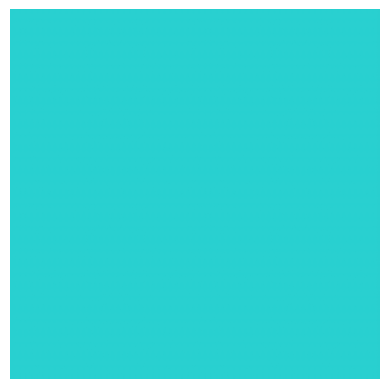

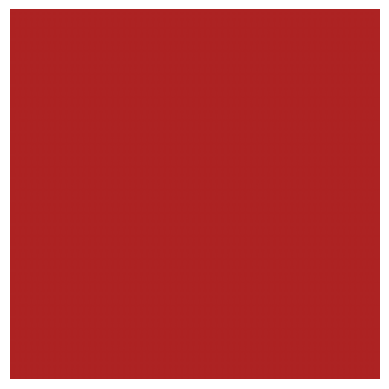

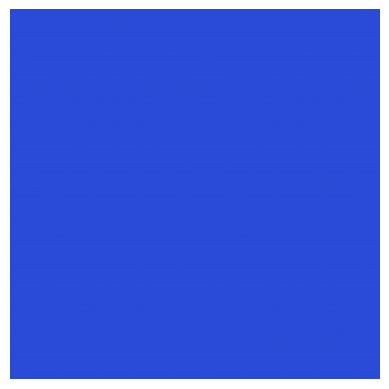

In [32]:
for cue in (cue1, cue2, cue3):
    plt.imshow(to_rgb_from_tensor(cue).numpy().transpose(1, 2, 0))
    plt.axis('off')
    plt.show()

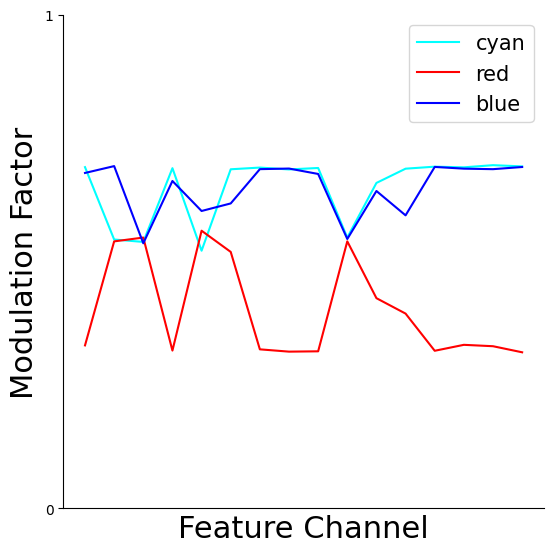

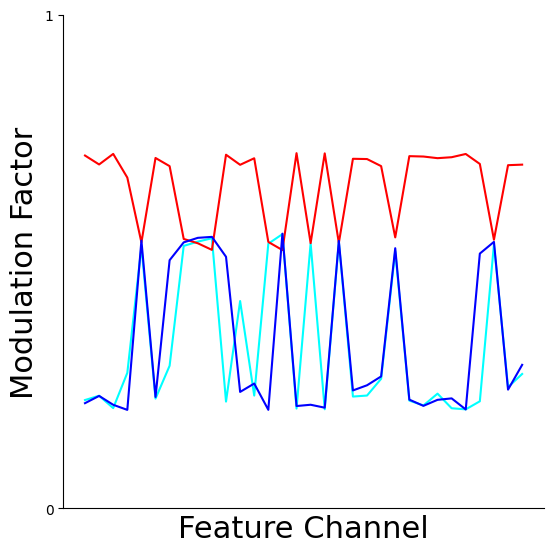

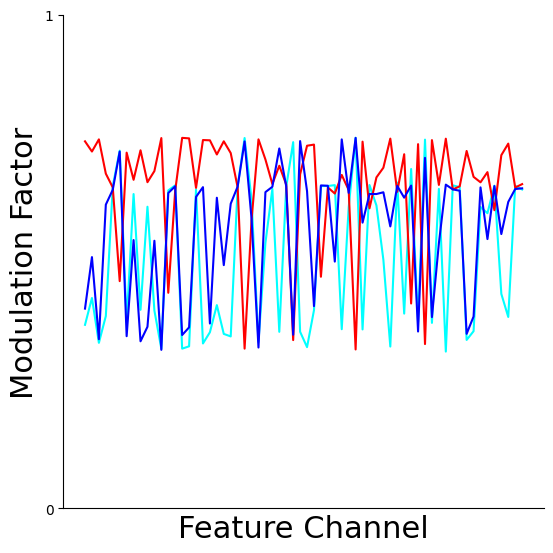

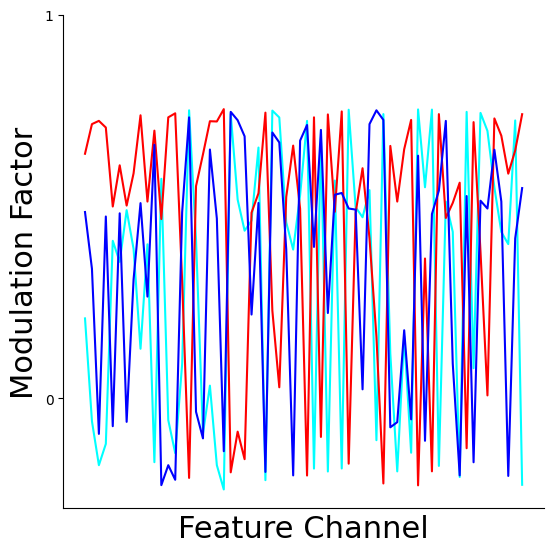

In [33]:
plt.rcParams.update({'font.size': 22})

num_layers = len(factors[0])
bar_width = 0.2

for l in range(num_layers):
    fig, ax = plt.subplots(figsize=(6, 6))

    num_colors = len(cue_colors)
    num_channels = factors[0][l].shape[1]

    indices = torch.arange(1, num_channels + 1)
    group_width = num_colors * bar_width

    for i, (factor, cue_color) in enumerate(zip(factors, cue_colors)):
        # bar_positions = indices - (group_width / 2) + (i * bar_width) + (bar_width / 2)
        cue_factors = factor[l].flatten(start_dim=-2).mean(dim=-1).squeeze().cpu()
        plt.plot(cue_factors, alpha=1.0, color=cue_color, label=cue_color)
        # ax.bar(bar_positions, cue_factors, bar_width, alpha=0.5, color=cue_color, label=cue_color)


    # plt.title('Modulating Factors for Layer {}'.format(l + 1))
    plt.xlabel('Feature Channel')
    plt.ylabel('Modulation Factor')

    ax = plt.gca()

    ax.xaxis.set_tick_params(labelbottom=False)
    # ax.yaxis.set_tick_params(labelleft=False)
    ax.set_xticks([])
    ax.set_yticks([0, 1])
    plt.yticks(fontsize=10)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if l == 0:
        ax.legend(fontsize=15, loc='upper right', bbox_to_anchor=(1, 1))

    plt.tight_layout()

    fig.savefig('./{}_color.pdf'.format(l))   

In [34]:
torch.save(factors, 'factors_color.pt')

### Shape Plots


In [35]:
clevr_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Lambda(rescale),
        transforms.Resize(config.model.input_size),
    ]
)
val_dataset = qCLEVRDataset(
    data_root=config.data.root,
    assets_path=config.data.assets_path,
    clevr_transforms=clevr_transforms,
    return_images=config.save_results,
    split="valid",
    holdout=config.data.holdout,
    mode="shape",
    primitive=config.data.primitive,
    num_workers=config.data.num_workers,
)

*** Holding out: []
*** Mode: shape


In [36]:
cue1, mixture1, target1 = val_dataset[1]
cue2, mixture2, target2 = val_dataset[10]
cue3, mixture3, target3 = val_dataset[20]

cues = [cue1, cue2, cue3]
line_colors = ['red', 'green', 'cyan']
cue_shapes = ['cube', 'sphere', 'cylinder']
mixtures = [mixture1, mixture2, mixture3]
factors = []

bs = 1

with torch.no_grad():
    for cue, mixture in zip(cues, mixtures):
        cue = cue.unsqueeze(0).cuda()
        mixture = mixture.unsqueeze(0).cuda()

        out, factor = model.forward(cue, mixture)
        factors.append(factor)

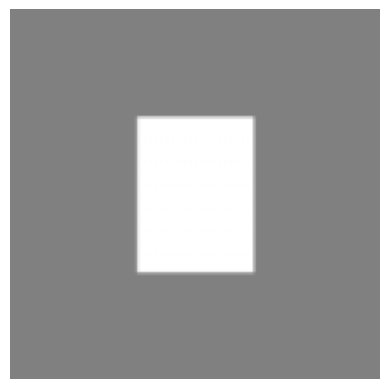

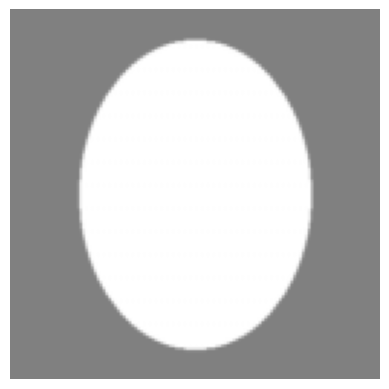

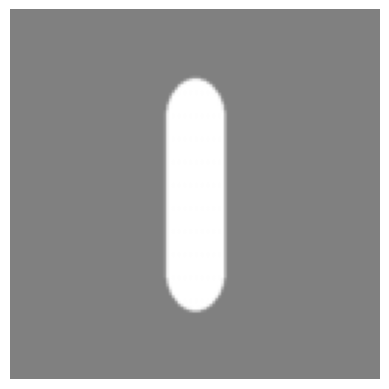

In [37]:
for cue in (cue1, cue2, cue3):
    plt.imshow(to_rgb_from_tensor(cue).numpy().transpose(1, 2, 0))
    plt.axis('off')
    plt.show()

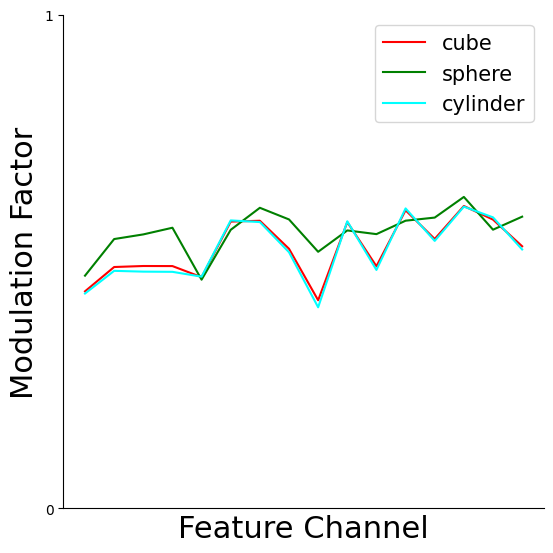

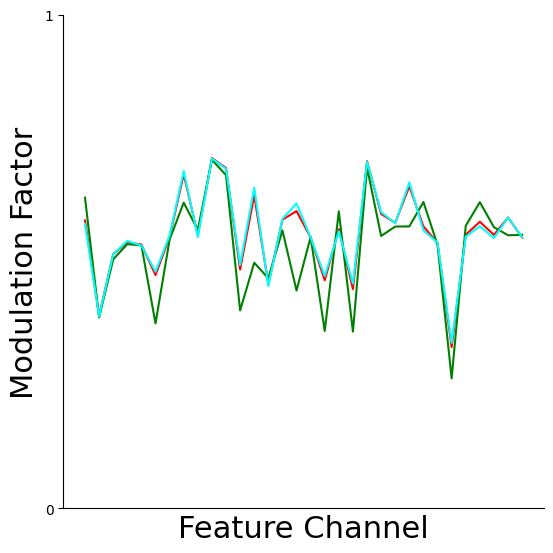

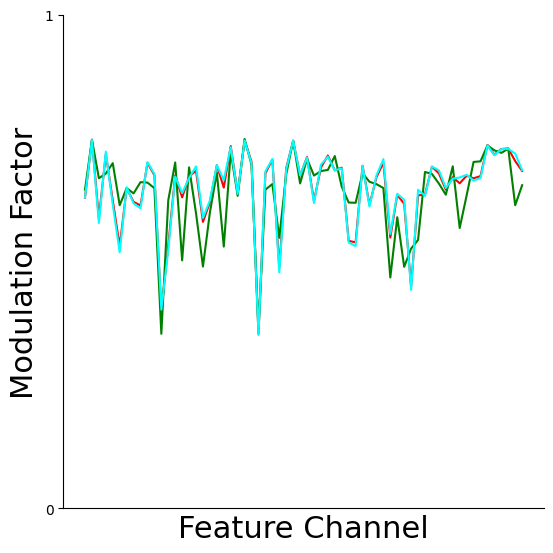

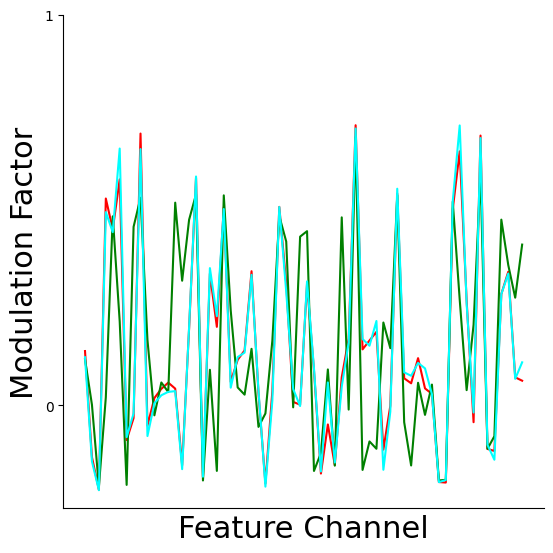

In [38]:
plt.rcParams.update({'font.size': 22})

num_layers = len(factors[0])
bar_width = 0.2

for l in range(num_layers):
    fig, ax = plt.subplots(figsize=(6, 6))

    num_channels = factors[0][l].shape[1]

    for i, (factor, cue_shape, line_color) in enumerate(zip(factors, cue_shapes, line_colors)):
        # bar_positions = indices - (group_width / 2) + (i * bar_width) + (bar_width / 2)
        cue_factors = factor[l].flatten(start_dim=-2).mean(dim=-1).squeeze().cpu()
        plt.plot(cue_factors, alpha=1.0, color=line_color, label=cue_shape)
        # ax.bar(bar_positions, cue_factors, bar_width, alpha=0.5, color=cue_color, label=cue_color)


    # plt.title('Modulating Factors for Layer {}'.format(l + 1))
    plt.xlabel('Feature Channel')
    plt.ylabel('Modulation Factor')

    ax = plt.gca()

    ax.xaxis.set_tick_params(labelbottom=False)
    # ax.yaxis.set_tick_params(labelleft=False)
    ax.set_xticks([])
    ax.set_yticks([0, 1])
    plt.yticks(fontsize=10)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if l == 0:
        ax.legend(fontsize=15, loc='upper right', bbox_to_anchor=(1,1))

    plt.tight_layout()

    fig.savefig('./{}_shape.pdf'.format(l))   

In [39]:
torch.save(factors, 'factors_shape.pt')

### Conjunction Plots


In [40]:
clevr_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Lambda(rescale),
        transforms.Resize(config.model.input_size),
    ]
)
val_dataset = qCLEVRDataset(
    data_root=config.data.root,
    assets_path=config.data.assets_path,
    clevr_transforms=clevr_transforms,
    return_images=config.save_results,
    split="valid",
    holdout=config.data.holdout,
    mode="conjunction",
    primitive=config.data.primitive,
    num_workers=config.data.num_workers,
)

*** Holding out: []
*** Mode: conjunction


In [41]:
cue1, mixture1, target1 = val_dataset[3]
cue2, mixture2, target2 = val_dataset[10]
cue3, mixture3, target3 = val_dataset[22]

cues = [cue1, cue2, cue3]
line_colors = ['red', 'green', 'cyan']
cue_shapes = ['yellow sphere', 'red cylinder', 'purple cube']
mixtures = [mixture1, mixture2, mixture3]
factors = []

bs = 1

with torch.no_grad():
    for cue, mixture in zip(cues, mixtures):
        cue = cue.unsqueeze(0).cuda()
        mixture = mixture.unsqueeze(0).cuda()

        out, factor = model.forward(cue, mixture)
        factors.append(factor)

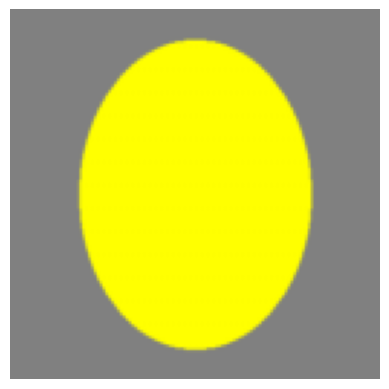

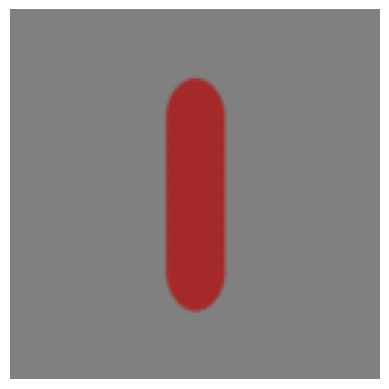

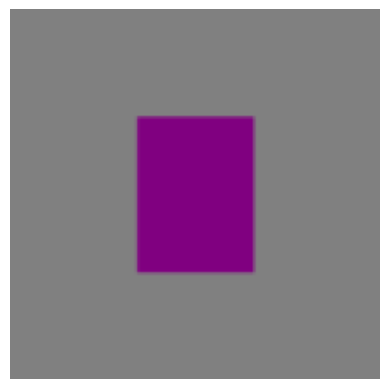

In [42]:
for cue in (cue1, cue2, cue3):
    plt.imshow(to_rgb_from_tensor(cue).numpy().transpose(1, 2, 0))
    plt.axis('off')
    plt.show()

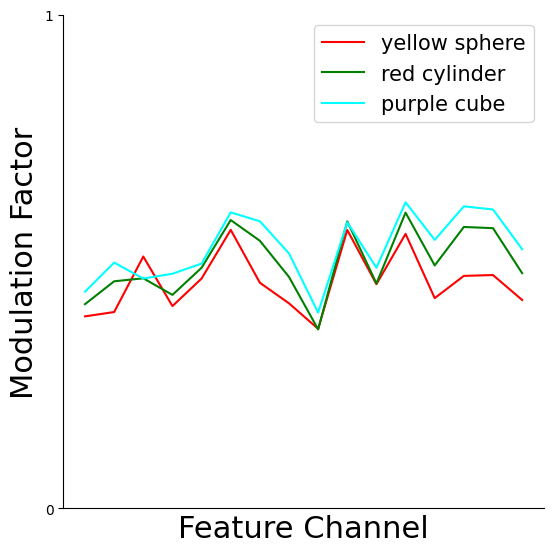

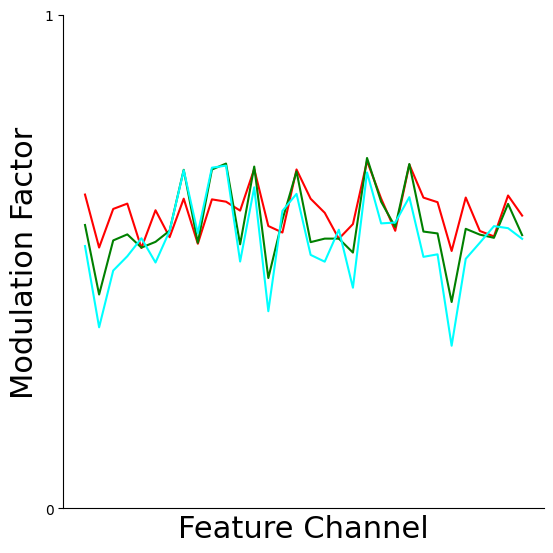

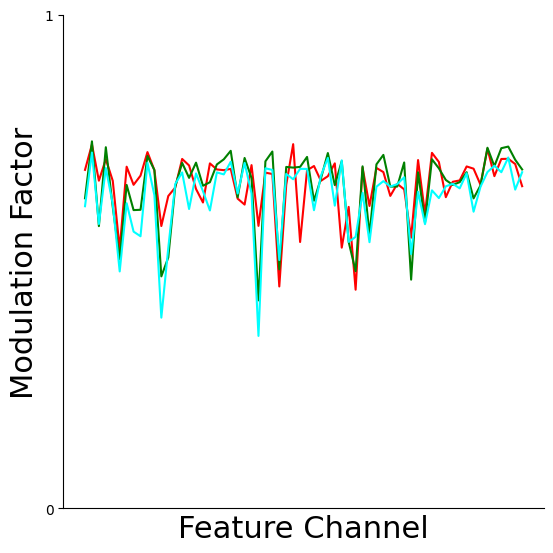

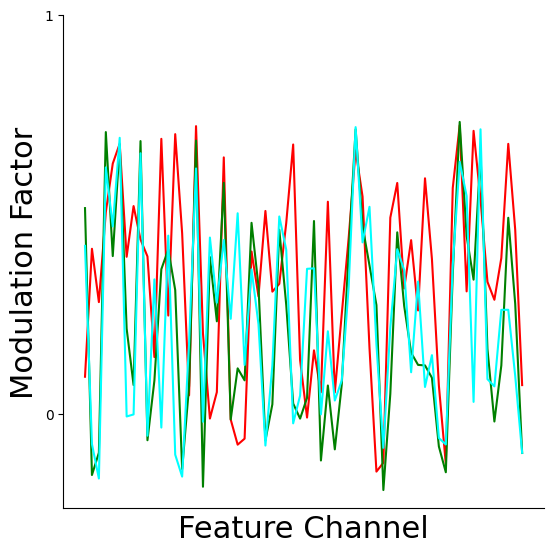

In [43]:
plt.rcParams.update({'font.size': 22})

num_layers = len(factors[0])
bar_width = 0.2

for l in range(num_layers):
    fig, ax = plt.subplots(figsize=(6, 6))

    num_channels = factors[0][l].shape[1]

    for i, (factor, cue_shape, line_color) in enumerate(zip(factors, cue_shapes, line_colors)):
        # bar_positions = indices - (group_width / 2) + (i * bar_width) + (bar_width / 2)
        cue_factors = factor[l].flatten(start_dim=-2).mean(dim=-1).squeeze().cpu()
        plt.plot(cue_factors, alpha=1.0, color=line_color, label=cue_shape)
        # ax.bar(bar_positions, cue_factors, bar_width, alpha=0.5, color=cue_color, label=cue_color)


    # plt.title('Modulating Factors for Layer {}'.format(l + 1))
    plt.xlabel('Feature Channel')
    plt.ylabel('Modulation Factor')

    ax = plt.gca()

    ax.xaxis.set_tick_params(labelbottom=False)
    # ax.yaxis.set_tick_params(labelleft=False)
    ax.set_xticks([])
    ax.set_yticks([0, 1])
    plt.yticks(fontsize=10)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if l == 0:
        ax.legend(fontsize=15, loc='upper right', bbox_to_anchor=(1,1))

    plt.tight_layout()

    fig.savefig('./{}_conjunction.pdf'.format(l))   

In [44]:
torch.save(factors, 'factors_conjunction.pt')